In [321]:
#(thlu = theta leg upper, thll = theta leg lower)


%reset
# DERIVE THE EOMs SYMBOLICALLY ----------------------------------------------------------------------------------------------

# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# create symbolic variables

# system parameters
g = sym.symbols('g')
mb,ml1,ml2 = sym.symbols(['m_{body}','m_{leg1}','m_{leg2}']) # mass
lb,ll1,ll2 = sym.symbols(['l_{body}','l_{leg1}','l_{leg2}']) # length
Inb,Inl1,Inl2 = sym.symbols(['I_{body}','I_{leg1}','I_{leg2}']) # moment of intertia

# generalized coordinates
x,y,thb,thlu,thll = sym.symbols(['x','y','\\theta_{body}','\\theta_{leg_upper}','\\theta_{leg_lower}']) 
dx,dy,dthb,dthlu,dthll = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{body}','\dot{\\theta}_{leg_upper}','\dot{\\theta}_{leg_lower}']) 
ddx,ddy,ddthb,ddthlu,ddthll = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{body}','\ddot{\\theta}_{leg_upper}','\ddot{\\theta}_{leg_lower}']) 

q = sym.Matrix([[x],[y],[thb],[thlu],[thll]])
dq = sym.Matrix([[dx],[dy],[dthb],[dthlu],[dthll]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb],[ddthlu],[ddthll]])

# forces
# total joint action = actuator + rebound, but that will be dealt with elsewhere
tau_hip,tau_knee,GRFx,GRFy = sym.symbols(['\\tau_hip','\\tau_knee','G_x','G_y']) 

# STEP 1: position vectors ri = [x,y,theta] (world frame)
rb = sym.Matrix([[x],
                [y],
                [thb]])

rl1 = sym.Matrix([[x - 0.5*ll1*sym.cos(thb + thlu)],
                [y - 0.5*ll1*sym.sin(thb + thlu)],
                [thb + thlu]])

rl2 = sym.Matrix([[x - ll1*sym.cos(thb + thlu)-(0.5*ll2)*sym.cos(thb + thlu+thll)],
                [y - ll1*sym.sin(thb + thlu)-(0.5*ll2)*sym.sin(thb + thlu+thll)],
                [thb + thlu+thll]])



# the Jacobians
Jb = rb.jacobian(q)
Jl1 = rl1.jacobian(q)
Jl2 = rl2.jacobian(q)

# STEP 2: generate expressions for the system space velocities from the jacobians
vb = Jb*dq
vl1 = Jl1*dq
vl2 = Jl2*dq

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([[mb,mb,Inb]])
Ml1 = sym.Matrix([[ml1,ml1,Inl1]])
Ml2 = sym.Matrix([[ml2,ml2,Inl2]])

T = 0.5*Mb*sym.matrix_multiply_elementwise(vb,vb) + 0.5*Ml1*sym.matrix_multiply_elementwise(vl1,vl1) + 0.5*Ml2*sym.matrix_multiply_elementwise(vl2,vl2)
T = T[0]
V = mb*g*rb[1] + ml1*g*rl1[1] + ml2*g*rl2[1]


# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# STEP 5: generalized forces

# force vectors for each link
tau_b = sym.Matrix([[0],[0],[-tau_hip]])
tau_l1 = sym.Matrix([[0],[0],[tau_hip - tau_knee]])
tau_l2 = sym.Matrix([[0],[0],[tau_knee]])

# F_l1 = sym.Matrix([[-F*sym.sin(thb+thlu)],[F*sym.cos(thb+thlu)],[0]])
# F_l2 = sym.Matrix([[+F*sym.cos(thb+thlu+thll)],[F*sym.sin(thb+thlu+thll)],[0]])

GRF_l2 = sym.Matrix([[GRFx],[GRFy],[(0.5*ll2*sym.sin(thb+thlu+thll)*GRFx) - (0.5*ll2*sym.cos(thb+thlu+thll)*GRFy)]])

Q = sym.zeros(len(q),1)
for j in range(len(q)):
    Q[j] = tau_b.transpose()*Jb[:,j]+(tau_l1).transpose()*Jl1[:,j]+(GRF_l2+tau_l2).transpose()*Jl2[:,j]

# AND combine!
EOM = Lg1 - Lg3 + Lg4 - Q

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()
    
# the simplification step is a little time-consuming so try to avoid re-running this cell if possible.

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [322]:
# Lambdify
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,ml1,ml2,lb,ll1,ll2,Inb,Inl1,Inl2,
            x,y,thb,thlu,thll,
            dx,dy,dthb,dthlu,dthll,
            ddx,ddy,ddthb,ddthlu,ddthll,
            tau_hip,tau_knee,GRFx,GRFy]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_thb = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_thlu = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_thll = sym.lambdify(sym_list,EOMs[4],modules = [func_map])

In [323]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 100
m.N = RangeSet(N) 

links = [('body',1),('leg',1),('leg',2)]
m.L = Set(dimen=2, initialize = links)

DOFs = ['x','y','theta_b','theta_lu','theta_ll'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81)

def get_m(n, lb, ln):
    if lb == 'body':
        return 5.0
    else: return 2.5
m.m = Param(m.L, initialize = get_m) # mass of links

def get_len(n, lb, ln):
    if lb == 'body':
        return 1.0
    else: return 0.5
m.len = Param(m.L, initialize = get_len) # length of links

def calculate_In(m, lb, ln): 
    l = (lb,ln)
    # yes, that does mean you have to rebuild the tuple inside the function. Yes, it is dumb.
    return m.m[l]*m.len[l]**2/12 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

mbody = sum(m.m[l] for l in links)
BW = mbody*m.g.value

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# bound variables
for n in range(1,N+1):
    for l in links:
        m.q[n,'y'].setlb(0.0)

In [324]:
# TIME AND INTEGRATION

# variable timestep
hm = 0.02 # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

In [325]:
# GROUND INTERACTIONS -------------------------------------------------------------------------------------------------------

# paramters
m.mu = Param(initialize = 1) # friction coefficient

# sign set for positive and negative components
signs = ['ps','ng'] 
m.sgn = Set(initialize = signs)

WDOFs = ['X','Y',"THETA"] # absolute coordinates (see what I mean about switching between frames the whole time...?)
m.WDOF = Set(initialize = WDOFs) 

# variables
m.footp = Var(m.N, m.WDOF, bounds = (0.0,None)) # foot position
m.footv = Var(m.N, m.WDOF, m.sgn, bounds = (0.0,None)) # foot velocity

m.friction_cone = Var(m.N, bounds = (0.0,None))

m.GRF = Var(m.N, m.WDOF, m.sgn, bounds = (0.0,None)) # ground reaction forces

ground_constraints = ['contact','friction','slip_ps','slip_ng'] 
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties
m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))

# constraints: aux variables
def def_footp(m,n,dof):
    if dof == 'Y':
#         L = 0.5*m.len[('leg',1)]  + 0.5*m.len[('leg',2)] # total leg length
#         thA = m.q[n,'theta_b'] + m.q[n,'theta_lu'] + m.q[n,'theta_ll'] # absolute leg angle
        thA=(m.q[n,'theta_b'] + m.q[n,'theta_lu'])
        thB=(m.q[n,'theta_b'] +m.q[n,'theta_lu']+ m.q[n,'theta_ll'])

        return m.footp[n,dof] ==  m.q[n,'y'] - (m.len[('leg',1)]*sin(thA))-(m.len[('leg',2)]*sin(thB))
        
    else:
        return Constraint.Skip
m.def_footp = Constraint(m.N, m.WDOF, rule = def_footp)

# lambdify the foot velocity
thA=(thb + thlu)
thB=(thb + thlu + thll)

#footx = sym.Matrix([x + (0.5*ll1+0.5*ll2)*sym.sin(thb + thlu + thll)])
footx = sym.Matrix([x - (ll1*sym.cos(thA))-(ll2*sym.cos(thB))])
footdx = footx.jacobian(q)*dq
footdx = footdx[0].simplify()
lamb_footdx = sym.lambdify(sym_list,footdx,modules = [func_map])

def def_footv(m,n,dof):
    if dof == 'X':
        var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            0,0,0,0]
        return m.footv[n,dof,'ps']-m.footv[n,dof,'ng'] == lamb_footdx(*var_list)
    else:
        return Constraint.Skip
m.def_footv = Constraint(m.N, m.WDOF, rule = def_footv)

def def_friction_cone(m,n):
    return m.friction_cone[n] == m.mu*m.GRF[n,'Y','ps'] - (m.GRF[n,'X','ps'] + m.GRF[n,'X','ng'])
m.def_friction_cone = Constraint(m.N, rule = def_friction_cone)

# constraints: complementarity

# contact
def ground_contact(m,n):
    if n < N:
        return m.ground_penalty[n,'contact'] == m.footp[n+1,'Y']*m.GRF[n,'Y','ps'] 
    else:
        return Constraint.Skip
m.ground_contact = Constraint(m.N, rule = ground_contact)

# friction
def ground_friction(m,n):
    return m.ground_penalty[n,'friction'] == (m.footv[n,'X','ps']+m.footv[n,'X','ng'])*m.friction_cone[n]
m.ground_friction = Constraint(m.N, rule = ground_friction)

# slipping
def ground_slip_ps(m,n):
    return m.ground_penalty[n,'slip_ps'] == m.footv[n,'X','ps']*m.GRF[n,'X','ps']
m.ground_slip_ps = Constraint(m.N, rule = ground_slip_ps)

def ground_slip_ng(m,n):
    return m.ground_penalty[n,'slip_ng'] == m.footv[n,'X','ng']*m.GRF[n,'X','ng']
m.ground_slip_ng = Constraint(m.N, rule = ground_slip_ng)

# bound contact forces at last node
for dof in WDOFs:
    for sgn in signs:
        m.GRF[N,dof,sgn].value = 0
        m.GRF[N,dof,sgn].fixed = True

In [326]:
# HARD JOINT STOPS ----------------------------------------------------------------------------------------------------------

# sets
joints = ['hip','knee']
m.J = Set(initialize = joints)

joint_constraints = ['up','lo'] # set of joint penalties
m.joint_constraints = Set(initialize = joint_constraints)

# parameters
hip_bound = [0,np.pi]
m.hip_bound = Param(m.joint_constraints, initialize = {'up':hip_bound[1],'lo':hip_bound[0]}) 

knee_bound = [-np.pi/2,np.pi/2]
m.knee_bound = Param(m.joint_constraints, initialize = {'up':knee_bound[1],'lo':knee_bound[0]})

# we can bound the joint coordinates directly
for n in range(1,N+1):
    m.q[n,'theta_lu'].setlb(hip_bound[0])
    m.q[n,'theta_lu'].setub(hip_bound[1])
    m.q[n,'theta_ll'].setlb(hip_bound[0])
    m.q[n,'theta_ll'].setub(hip_bound[1])

# variables
m.tau_a = Var(m.N, bounds = (-2,2)) # actuator torque at hip
m.tau_r1 = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound torque

m.tau_b = Var(m.N, bounds = (-2,2)) # actuator torque at knee
m.tau_r2 = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound torque


m.F_a = Var(m.N, bounds = (-3,3)) # actuator force at knee
m.F_r = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound force (acts parallel to the leg)

m.joint_penalty = Var(m.N, m.J, m.joint_constraints, bounds = (0.0,None))

# complementarity
def hip_limits(m,n,jc):
    if n < N:
        if jc == 'up':
            # NEXT angle
            return m.joint_penalty[n,'hip',jc] == (m.hip_bound['up'] - m.q[n+1,'theta_lu']-m.q[n+1,'theta_ll'])*m.tau_r1[n,'ng']
        else:
            return m.joint_penalty[n,'hip',jc] == (m.q[n+1,'theta_lu'] + m.q[n+1,'theta_ll']- m.hip_bound['lo'])*m.tau_r1[n,'ps']
    else:
        return Constraint.Skip
m.hip_limits = Constraint(m.N, m.joint_constraints, rule = hip_limits)

def knee_limits(m,n,jc):
    if n < N:
        if jc == 'up':
            # NEXT distance
            return m.joint_penalty[n,'knee',jc] == (m.knee_bound['up'] )*m.F_r[n,'ng']
        else:
            return m.joint_penalty[n,'knee',jc] == ( - m.knee_bound['lo'])*m.F_r[n,'ps']
    else:
        return Constraint.Skip
m.knee_limits = Constraint(m.N, m.joint_constraints, rule = knee_limits)

#bound contact forces at last node
for sgn in signs:
    m.F_r[N,sgn].value = 0
    m.F_r[N,sgn].fixed = True

for sgn in signs:
    m.tau_r1[N,sgn].value = 0
    m.tau_r1[N,sgn].fixed = True
    m.tau_r2[N,sgn].value = 0
    m.tau_r2[N,sgn].fixed = True

In [327]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------

# minimum time

def CostFun(m):
    T = sum(m.h[n] for n in range(1,N+1))       #time constraint
    penalty_sum = 0
    for n in range(1,N+1):
        for gc in ground_constraints:             #ground constraints
            penalty_sum += m.ground_penalty[n,gc] #ground constraints  
#         for jc in joint_constraints:              #hard stop constraints
#             for j in joints:                       #hard stop constraints
#                 penalty_sum += m.joint_penalty[n,j,jc] #hard stop constraints
    return T+1000*penalty_sum
m.Cost = Objective(rule = CostFun)

In [328]:
# EQUATIONS OF MOTION -------------------------------------------------------------------------------------------------------
S = BW

def EOM_x(m,n):
    F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            F_in,tau_in,Gx_in,Gy_in]
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, rule = EOM_x)

def EOM_y(m,n):
    F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            F_in,tau_in,Gx_in,Gy_in]
    return lambEOM_y(*var_list) == 0
m.EOM_y = Constraint(m.N, rule = EOM_y)

def EOM_thb(m,n):
    F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            F_in,tau_in,Gx_in,Gy_in]
    return lambEOM_thb(*var_list) == 0
m.EOM_thb = Constraint(m.N, rule = EOM_thb)

def EOM_thlu(m,n):
    F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            F_in,tau_in,Gx_in,Gy_in]
    return lambEOM_thlu(*var_list) == 0
m.EOM_thlu = Constraint(m.N, rule = EOM_thlu)

def EOM_thll(m,n):
    F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            F_in,tau_in,Gx_in,Gy_in]
    return lambEOM_thll(*var_list) == 0
m.EOM_thll = Constraint(m.N, rule = EOM_thll)

In [332]:
# HIGH DROP -----------------------------------------------------------------------------------------------------------------

# initial condition
m.q[1,'x'].value = 0.0
m.q[1,'y'].value = 30.0
m.q[1,'theta_b'].value = 0.0
m.q[1,'theta_lu'].value = np.pi/2
m.q[1,'theta_ll'].value = 0.0

for dof in DOFs:
    m.q[1,dof].fixed = True
    m.dq[1,dof].value = 0.0
    m.dq[1,dof].fixed = True
    
for n in range(1,N+1):
    m.F_a[n].value = 0.0
    m.F_a[n].fixed = True
    m.tau_a[n].value = 0.0
    m.tau_a[n].fixed = True
    m.tau_b[n].value = 0.0
    m.tau_b[n].fixed = True

    
# m.q[N,'x'].value = 0.0
# m.q[N,'y'].value = 0.0
# m.q[N,'theta_b'].value = 0.0
# m.q[N,'theta_lu'].value = 0.0
# m.q[N,'theta_ll'].value = 0.0
    
m.pprint()


24 Set Declarations
    DOF : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'x', 'y', 'theta_b', 'theta_lu', 'theta_ll'}
    F_r_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :  N*sgn :  200 : {(1, 'ps'), (1, 'ng'), (2, 'ps'), (2, 'ng'), (3, 'ps'), (3, 'ng'), (4, 'ps'), (4, 'ng'), (5, 'ps'), (5, 'ng'), (6, 'ps'), (6, 'ng'), (7, 'ps'), (7, 'ng'), (8, 'ps'), (8, 'ng'), (9, 'ps'), (9, 'ng'), (10, 'ps'), (10, 'ng'), (11, 'ps'), (11, 'ng'), (12, 'ps'), (12, 'ng'), (13, 'ps'), (13, 'ng'), (14, 'ps'), (14, 'ng'), (15, 'ps'), (15, 'ng'), (16, 'ps'), (16, 'ng'), (17, 'ps'), (17, 'ng'), (18, 'ps'), (18, 'ng'), (19, 'ps'), (19, 'ng'), (20, 'ps'), (20, 'ng'), (21, 'ps'), (21, 'ng'), (22, 'ps'), (22, 'ng'), (23, 'ps'), (23, 'ng'), (24, 'ps'), (24, 'ng'), (25, 'ps'), (25, 'ng'), (26, 'ps'), (26, 'ng'), (27, 'ps'), (27, 'ng'), (28, 'ps'), (28, 'ng'), (29, 'ps')

             (18, 'X') :   0.0 :               None :  None : False :  True :  Reals
             (18, 'Y') :   0.0 : 19.928236494982407 :  None : False : False :  Reals
         (19, 'THETA') :   0.0 :               None :  None : False :  True :  Reals
             (19, 'X') :   0.0 :               None :  None : False :  True :  Reals
             (19, 'Y') :   0.0 : 19.862650340183656 :  None : False : False :  Reals
         (20, 'THETA') :   0.0 :               None :  None : False :  True :  Reals
             (20, 'X') :   0.0 :               None :  None : False :  True :  Reals
             (20, 'Y') :   0.0 : 19.427631261567434 :  None : False : False :  Reals
         (21, 'THETA') :   0.0 :               None :  None : False :  True :  Reals
             (21, 'X') :   0.0 :               None :  None : False :  True :  Reals
             (21, 'Y') :   0.0 :  19.57765074752755 :  None : False : False :  Reals
         (22, 'THETA') :   0.0 :               None :  None : Fal

         (28, 'theta_lu') :     0 :     2.2572629165823317 : 3.141592653589793 : False : False :  Reals
                (28, 'x') :  None :    -1.2739042215430108 :              None : False : False :  Reals
                (28, 'y') :   0.0 :     19.108801401355933 :              None : False : False :  Reals
          (29, 'theta_b') :  None :    -1.5646481906746224 :              None : False : False :  Reals
         (29, 'theta_ll') :     0 :     0.7771800794852644 : 3.141592653589793 : False : False :  Reals
         (29, 'theta_lu') :     0 :      2.622367802282531 : 3.141592653589793 : False : False :  Reals
                (29, 'x') :  None :    -1.3580763540058671 :              None : False : False :  Reals
                (29, 'y') :   0.0 :      18.99550199971883 :              None : False : False :  Reals
          (30, 'theta_b') :  None :     -1.578591538361346 :              None : False : False :  Reals
         (30, 'theta_ll') :     0 :     0.4334125717247287 : 3.1

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key        : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                    : Upper : Active
          (1, 'X') :   0.0 :                                       footv[1,X,ps] - footv[1,X,ng] - (0.5*dq[1,theta_ll]*sin(q[1,theta_lu] + q[1,theta_ll] + q[1,theta_b]) + dq[1,x] + dq[1,theta_lu]*(0.5*sin(q[1,theta_lu] + q[1,theta_ll] + q[1,theta_b]) + 0.5*sin(q[1,theta_lu] + q[1,theta_b])) + dq[1,theta_b]*(0.5*sin(q[1,theta_lu] + q[1,theta_ll] + q[1,theta_b]) + 0.5*sin(q[1,theta_lu] + q[1,theta_b]))) :   0.0 :   True
          (2, 'X') :   0.0 :                                       footv[2,X,ps] - footv[2,X,ng] - (0.5*dq[2,theta_ll]*sin(q[2,theta_lu] + q[2,theta_ll] + q

        Key : Lower : Body                                                        : Upper : Active
          1 :   0.0 :       ground_penalty[1,slip_ng] - footv[1,X,ng]*GRF[1,X,ng] :   0.0 :   True
          2 :   0.0 :       ground_penalty[2,slip_ng] - footv[2,X,ng]*GRF[2,X,ng] :   0.0 :   True
          3 :   0.0 :       ground_penalty[3,slip_ng] - footv[3,X,ng]*GRF[3,X,ng] :   0.0 :   True
          4 :   0.0 :       ground_penalty[4,slip_ng] - footv[4,X,ng]*GRF[4,X,ng] :   0.0 :   True
          5 :   0.0 :       ground_penalty[5,slip_ng] - footv[5,X,ng]*GRF[5,X,ng] :   0.0 :   True
          6 :   0.0 :       ground_penalty[6,slip_ng] - footv[6,X,ng]*GRF[6,X,ng] :   0.0 :   True
          7 :   0.0 :       ground_penalty[7,slip_ng] - footv[7,X,ng]*GRF[7,X,ng] :   0.0 :   True
          8 :   0.0 :       ground_penalty[8,slip_ng] - footv[8,X,ng]*GRF[8,X,ng] :   0.0 :   True
          9 :   0.0 :       ground_penalty[9,slip_ng] - footv[9,X,ng]*GRF[9,X,ng] :   0.0 :   True
         1

        Key               : Lower : Body                                                              : Upper : Active
           (2, 'theta_b') :   0.0 :           q[2,theta_b] - (q[1,theta_b] + 0.02*h[2]*dq[2,theta_b]) :   0.0 :   True
          (2, 'theta_ll') :   0.0 :        q[2,theta_ll] - (q[1,theta_ll] + 0.02*h[2]*dq[2,theta_ll]) :   0.0 :   True
          (2, 'theta_lu') :   0.0 :        q[2,theta_lu] - (q[1,theta_lu] + 0.02*h[2]*dq[2,theta_lu]) :   0.0 :   True
                 (2, 'x') :   0.0 :                             q[2,x] - (q[1,x] + 0.02*h[2]*dq[2,x]) :   0.0 :   True
                 (2, 'y') :   0.0 :                             q[2,y] - (q[1,y] + 0.02*h[2]*dq[2,y]) :   0.0 :   True
           (3, 'theta_b') :   0.0 :           q[3,theta_b] - (q[2,theta_b] + 0.02*h[3]*dq[3,theta_b]) :   0.0 :   True
          (3, 'theta_ll') :   0.0 :        q[3,theta_ll] - (q[2,theta_ll] + 0.02*h[3]*dq[3,theta_ll]) :   0.0 :   True
          (3, 'theta_lu') :   0.0 :        q[3,t

        Key               : Lower : Body                                                                : Upper : Active
           (2, 'theta_b') :   0.0 :          dq[2,theta_b] - (dq[1,theta_b] + 0.02*h[2]*ddq[1,theta_b]) :   0.0 :   True
          (2, 'theta_ll') :   0.0 :       dq[2,theta_ll] - (dq[1,theta_ll] + 0.02*h[2]*ddq[1,theta_ll]) :   0.0 :   True
          (2, 'theta_lu') :   0.0 :       dq[2,theta_lu] - (dq[1,theta_lu] + 0.02*h[2]*ddq[1,theta_lu]) :   0.0 :   True
                 (2, 'x') :   0.0 :                            dq[2,x] - (dq[1,x] + 0.02*h[2]*ddq[1,x]) :   0.0 :   True
                 (2, 'y') :   0.0 :                            dq[2,y] - (dq[1,y] + 0.02*h[2]*ddq[1,y]) :   0.0 :   True
           (3, 'theta_b') :   0.0 :          dq[3,theta_b] - (dq[2,theta_b] + 0.02*h[3]*ddq[2,theta_b]) :   0.0 :   True
          (3, 'theta_ll') :   0.0 :       dq[3,theta_ll] - (dq[2,theta_ll] + 0.02*h[3]*ddq[2,theta_ll]) :   0.0 :   True
          (3, 'theta_lu') :   0.

In [182]:
# # INITIALIZE ----------------------------------------------------------------------------------------------------------------
# guide = np.linspace(0,5.0,N)
# for n in range(1,N+1):
#     m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#     m.q[n,'y'].value  = np.random.uniform(0,3)
#     m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/2,np.pi/2)
#     m.q[n,'theta_lu'].value  = np.random.uniform(0,np.pi)
#     m.q[n,'theta_ll'].value  = np.random.uniform(-np.pi/2,np.pi/2)
    
#     m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
#     m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value

In [166]:
# # SPRINT --------------------------------------------------------------------------------------------------------------------
# # tax day

# # initial condition
# m.q[1,'x'].value = 0.0
# m.q[1,'theta_b'].value = 0.0
# m.q[1,'theta_lu'].value = np.pi/2
# m.q[1,'theta_ll'].value = 0.0

# m.q[1,'x'].fixed = True
# m.q[1,'theta_b'].fixed = True
# m.q[1,'theta_lu'].fixed = True
# m.q[1,'theta_ll'].fixed = True

# m.footp[1,'Y'].value = 0.0
# m.footp[1,'Y'].fixed = True

# for dof in DOFs:
#     m.dq[1,dof].value = 0.0
#     m.dq[1,dof].fixed = True
      
# # final condition
# m.q[N,'x'].setlb(5.0)

# m.dq[N,'x'].value = 0.0
# m.dq[N,'x'].fixed = 0.0
# m.dq[N,'theta_b'].value = 0.0
# m.dq[N,'theta_b'].fixed = 0.0
# m.dq[N,'theta_lu'].value = 0.0
# m.dq[N,'theta_lu'].fixed = 0.0
# m.dq[N,'theta_ll'].value = 0.0
# m.dq[N,'theta_ll'].fixed = 0.0

# m.q[N,'theta_b'].value = 0.0
# m.q[N,'theta_lu'].value = 0.0
# m.q[N,'theta_ll'].value = 0.0
# m.q[N,'theta_b'].fixed = True
# m.q[N,'theta_lu'].fixed = True
# m.q[N,'theta_ll'].fixed = True

# m.footp[N,'Y'].value = 0.0
# m.footp[N,'Y'].fixed = True
    
# #m.pprint()

In [333]:
# solving
#opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
from pyomo.opt import SolverFactory
opt = SolverFactory('ipopt',executable = 'C:/cygwin64/home/Yousuf/CoinIpopt/build/bin/ipopt.exe')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000 # maximum number of iterations
opt.options["max_cpu_time"] = 600 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee = True) 

Ipopt 3.12.12: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    15170
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6329

Total number of variables............................:     3677
                     variables with only lower bounds:     2186
                variables with lower and upper bounds:      298
                     variables with only 

  77  2.6818710e+03 9.81e+02 9.14e+01  -1.0 6.40e+03    -  7.44e-02 3.86e-02f  1
  78  2.0491331e+03 8.67e+02 8.56e+01  -1.0 5.78e+03    -  6.05e-02 1.16e-01f  1
  79  2.0437907e+03 8.67e+02 1.02e+02  -1.0 6.91e+01   4.0 1.74e-04 7.28e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  2.0469759e+03 8.67e+02 1.01e+02  -1.0 7.08e+01   3.5 1.57e-04 1.97e-04h  1
  81  2.0572717e+03 8.67e+02 1.14e+02  -1.0 7.12e+01   3.1 2.28e-04 1.94e-04h  1
  82  2.0964099e+03 8.66e+02 1.34e+02  -1.0 7.15e+01   2.6 4.96e-04 7.43e-04h  1
  83  2.1249691e+03 8.65e+02 1.40e+02  -1.0 7.20e+01   2.1 1.37e-03 6.40e-04h  1
  84  2.2713714e+03 8.61e+02 1.53e+02  -1.0 7.21e+01   1.6 1.49e-03 4.74e-03h  1
  85  2.4683888e+03 8.51e+02 1.64e+02  -1.0 7.24e+01   1.1 1.10e-02 1.21e-02h  1
  86  2.4611996e+03 8.50e+02 5.89e+02  -1.0 7.25e+01   0.7 1.02e-01 5.86e-04h  1
  87  2.2410677e+03 8.41e+02 1.10e+03  -1.0 7.58e+01   0.2 2.42e-01 1.11e-02f  1
  88  2.1835056e+03 8.17e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  8.5477461e+01 4.75e-01 8.46e+00  -5.7 2.59e+01  -5.1 4.15e-01 3.86e-02h  1
 171  8.5389972e+01 5.20e-01 3.39e+00  -5.7 9.18e+00  -4.7 1.00e+00 2.05e-01h  1
 172  8.5142453e+01 1.55e+00 5.47e+00  -5.7 2.66e+01  -5.1 4.98e-01 1.99e-01h  1
 173  8.5023698e+01 1.49e+00 6.73e+00  -5.7 8.77e+00  -4.7 1.00e+00 3.01e-01h  1
 174  8.5014342e+01 1.48e+00 8.28e+00  -5.7 2.59e+01  -5.2 3.14e-01 8.93e-03h  1
 175  8.4962996e+01 1.26e+00 6.64e+00  -5.7 9.95e+00  -4.8 1.00e+00 1.46e-01h  1
 176  8.4810765e+01 1.14e+00 5.94e+00  -5.7 2.81e+01  -5.2 2.39e-01 1.51e-01h  1
 177  8.4737500e+01 1.03e+00 8.18e+00  -5.7 1.09e+01  -4.8 1.00e+00 1.89e-01h  1
 178  8.4594153e+01 1.45e+00 6.88e+00  -5.7 3.12e+01  -5.3 1.65e-01 1.57e-01h  1
 179  8.4582887e+01 1.41e+00 7.67e+00  -5.7 1.07e+01  -4.9 1.00e+00 3.48e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  8.4371908e+01 2.28e+00

 265  8.1054775e+01 9.39e-01 1.09e+00  -5.7 1.51e+01  -6.0 1.00e+00 4.06e-01h  1
 266  8.1030590e+01 9.37e-01 2.11e+00  -5.7 4.39e+01  -6.5 5.02e-01 1.97e-01h  1
 267  8.1015923e+01 9.13e-01 7.04e+00  -5.7 1.04e+02  -6.9 5.73e-01 4.68e-02h  1
 268  8.0930780e+01 4.32e+00 1.13e+01  -5.7 2.61e+02  -7.4 2.63e-01 9.77e-02h  1
 269  8.0902798e+01 4.28e+00 4.84e+00  -5.7 7.42e+02  -7.9 1.24e-01 1.57e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  8.0857369e+01 3.98e+00 1.68e+01  -5.7 2.65e+02  -7.5 6.66e-01 7.28e-02h  1
 271  8.0842279e+01 2.00e+00 2.69e-01  -5.7 1.27e+01  -6.1 1.00e+00 4.98e-01h  1
 272  8.0816811e+01 1.40e+00 4.95e-01  -5.7 3.73e+01  -6.6 4.02e-01 3.04e-01h  1
 273  8.0691157e+01 4.75e+00 1.13e+00  -5.7 1.14e+02  -7.1 6.13e-01 5.16e-01h  1
 274  8.0644834e+01 5.03e+00 2.68e+00  -5.7 3.32e+02  -7.6 1.98e-01 6.71e-02h  1
 275  8.0633091e+01 4.74e+00 2.77e+00  -5.7 1.21e+02  -7.1 1.92e-01 5.99e-02h  1
 276  8.0622143e+01 4.07e+00

 359  8.0016717e+01 3.48e+01 7.09e+01  -7.0 1.37e+01  -4.8 7.99e-03 6.98e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  8.0016722e+01 3.43e+01 6.99e+01  -7.0 3.31e+00  -4.3 9.85e-02 1.44e-02h  1
 361  8.0016787e+01 3.00e+01 6.10e+01  -7.0 3.36e+00  -4.8 4.26e-02 1.26e-01h  1
 362  8.0017099e+01 2.20e+01 4.48e+01  -7.0 2.92e+00  -4.4 2.48e-01 2.66e-01h  1
 363  8.0017300e+01 1.22e+01 2.48e+01  -7.0 2.18e+00  -4.9 4.95e-01 4.47e-01h  1
 364  8.0017002e+01 8.66e+00 1.77e+01  -7.0 2.03e+00  -5.3 7.86e-01 2.89e-01h  1
 365  8.0016828e+01 8.27e+00 1.71e+01  -7.0 5.60e+00  -5.8 5.01e-01 4.40e-02h  1
 366  8.0016806e+01 7.46e+00 1.54e+01  -7.0 1.87e+00  -5.4 2.46e-01 9.81e-02h  1
 367  8.0016514e+01 5.26e+00 1.08e+01  -7.0 3.32e+00  -5.9 2.45e-01 2.96e-01h  1
 368  8.0016040e+01 4.36e+00 9.02e+00  -7.0 8.47e+00  -6.4 1.30e-01 1.70e-01h  1
 369  8.0015597e+01 2.19e+00 4.62e+00  -7.0 3.08e+00  -5.9 2.92e-01 4.98e-01h  1
iter    objective    inf_pr 

 456  7.9996487e+01 8.27e-05 1.64e-05  -7.0 1.45e-01  -7.7 1.00e+00 1.00e+00h  1
 457  7.9996487e+01 5.31e-04 3.27e-05  -7.0 3.74e-01  -8.2 1.00e+00 1.00e+00h  1
 458  7.9996487e+01 3.49e-03 2.38e-04  -7.0 9.71e-01  -8.7 1.00e+00 1.00e+00h  1
 459  7.9996487e+01 2.22e-02 3.77e-03  -7.0 2.60e+00  -9.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460  7.9996487e+01 1.39e-01 3.95e-02  -7.0 7.04e+00  -9.6 1.00e+00 1.00e+00h  1
 461  7.9996487e+01 7.36e-01 2.42e-01  -7.0 1.78e+01 -10.1 1.00e+00 1.00e+00h  1
 462  7.9996488e+01 3.49e+00 7.62e-01  -7.0 4.20e+01 -10.6 1.00e+00 1.00e+00h  1
 463  7.9996488e+01 1.38e+01 1.31e+00  -7.0 9.06e+01 -11.0 1.00e+00 1.00e+00h  1
 464  7.9996488e+01 4.18e+01 1.77e+00  -7.0 2.38e+02 -11.5 1.00e+00 1.00e+00h  1
 465  7.9996488e+01 8.09e+01 3.31e+00  -7.0 5.44e+02 -12.0 1.00e+00 1.00e+00h  1
 466  7.9996488e+01 4.74e+02 5.82e+00  -7.0 1.11e+03 -12.5 8.82e-01 9.35e-01h  1
 467  7.9996488e+01 4.71e+02

 549  7.9996488e+01 6.44e+01 1.21e+00  -7.0 1.96e+03 -14.1 1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550  7.9996488e+01 6.49e+01 1.16e+00  -7.0 3.47e+03 -14.6 1.00e+00 5.15e-02h  5
 551  7.9996488e+01 6.44e+01 2.04e+00  -7.0 8.11e+03 -15.1 1.00e+00 7.81e-03h  8
 552  7.9996488e+01 6.44e+01 5.27e+00  -7.0 1.11e+05 -15.6 2.53e-01 6.79e-05h 13
 553  7.9996488e+01 1.20e+00 3.90e-02  -7.0 3.58e+01 -11.5 1.00e+00 1.00e+00h  1
 554  7.9996488e+01 1.43e+00 4.02e-02  -7.0 8.71e+01 -12.0 1.00e+00 1.00e+00h  1
 555  7.9996488e+01 9.58e+00 3.83e-02  -7.0 2.49e+02 -12.5 1.00e+00 1.00e+00h  1
 556  7.9996488e+01 6.83e+01 1.07e-01  -7.0 7.15e+02 -13.0 1.00e+00 1.00e+00h  1
 557  7.9996488e+01 3.53e+01 1.48e+00  -7.0 1.20e+03 -13.4 1.00e+00 1.00e+00H  1
 558  7.9996488e+01 7.15e+02 1.53e+00  -7.0 1.27e+03 -13.9 1.00e+00 1.00e+00h  1
 559  7.9996488e+01 7.21e+02 1.51e+00  -7.0 1.72e+03 -14.4 1.00e+00 1.25e-01h  4
iter    objective    inf_pr 

 644  9.3333383e+03 1.78e+03 9.98e+01  -7.0 1.27e+06 -11.5 1.07e-03 1.52e-04f  1
 645  9.1849100e+03 1.67e+03 9.98e+01  -7.0 2.18e+06 -12.0 7.27e-04 6.57e-04f  1
 646  8.9840300e+03 1.59e+03 9.97e+01  -7.0 1.68e+06 -11.5 5.03e-04 9.38e-04f  1
 647  8.9584131e+03 1.59e+03 9.96e+01  -7.0 7.13e+04  -9.3 3.81e-03 1.27e-04f  1
 648  8.9533531e+03 1.59e+03 9.96e+01  -7.0 5.09e+04  -9.8 5.11e-04 2.81e-05f  1
 649  8.7792301e+03 1.58e+03 9.95e+01  -7.0 1.05e+05 -10.3 7.41e-04 9.83e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650  8.7751882e+03 1.58e+03 9.95e+01  -7.0 1.15e+06  -9.8 8.60e-05 2.40e-05f  1
 651  8.6838862e+03 1.58e+03 9.94e+01  -7.0 7.50e+04 -10.3 1.82e-03 5.43e-04f  1
 652  8.5313692e+03 1.58e+03 9.92e+01  -7.0 1.25e+05 -10.8 1.88e-03 9.67e-04f  1
 653  8.2044823e+03 1.58e+03 9.92e+01  -7.0 2.60e+05 -11.3 3.24e-04 2.22e-03f  1
 654  8.1081845e+03 1.58e+03 9.91e+01  -7.0 8.15e+05 -11.7 1.00e-03 6.97e-04f  1
 655  7.8806080e+03 1.57e+03

 738  8.4305349e+01 5.26e+00 3.25e+00  -7.0 1.33e+01  -9.4 6.53e-01 3.25e-01h  1
 739  8.3270305e+01 3.99e+00 1.48e+00  -7.0 2.03e+01  -8.9 3.70e-02 2.40e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740  8.1622335e+01 1.96e+00 8.55e+00  -7.0 1.09e+01  -8.5 1.53e-01 5.03e-01h  1
 741  8.0997837e+01 1.17e+00 1.27e+01  -7.0 1.62e+01  -9.0 1.93e-01 3.84e-01h  1
 742  8.0262308e+01 3.43e-01 5.00e-01  -7.0 2.07e+01  -9.5 8.03e-01 7.34e-01h  1
 743  8.0153526e+01 1.24e+00 1.32e+01  -7.0 4.24e+01 -10.0 2.36e-01 4.09e-01h  1
 744  8.0085956e+01 2.39e+00 9.38e+00  -7.0 6.91e+01 -10.4 4.05e-01 4.30e-01h  1
 745  8.0043136e+01 3.19e+00 2.40e+01  -7.0 6.42e+01 -10.0 1.49e-01 4.78e-01h  1
 746  8.0023605e+01 1.93e+00 6.13e+00  -7.0 1.68e+01  -9.6 6.54e-01 4.18e-01h  1
 747  8.0009183e+01 9.42e-01 4.41e+01  -7.0 7.97e+00  -9.2 3.80e-01 5.31e-01h  1
 748  8.0003227e+01 4.97e-01 1.10e+02  -7.0 6.71e+00  -8.7 5.11e-01 4.77e-01h  1
 749  8.0001645e+01 3.70e-01

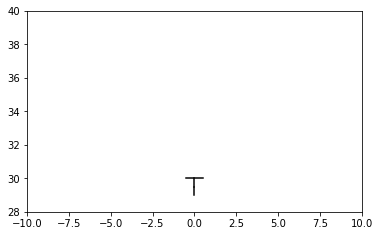

In [336]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-10,10])
    ax.set_ylim([28,40])
    
    #plot body
    body_xb = m.q[i,'x'].value - 0.5*m.len[('body',1)]*cos(m.q[i,'theta_b'].value)
    body_yb = m.q[i,'y'].value - 0.5*m.len[('body',1)]*sin(m.q[i,'theta_b'].value)
    body_xf = m.q[i,'x'].value + 0.5*m.len[('body',1)]*cos(m.q[i,'theta_b'].value)
    body_yf = m.q[i,'y'].value + 0.5*m.len[('body',1)]*sin(m.q[i,'theta_b'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black')
      
    #plot leg 1
    thA = m.q[i,'theta_b'].value+m.q[i,'theta_lu'].value
    leg1_xt = m.q[i,'x'].value
    leg1_yt = m.q[i,'y'].value
    leg1_xb = m.q[i,'x'].value + m.len[('leg',1)]*cos(thA)
    leg1_yb = m.q[i,'y'].value - m.len[('leg',1)]*sin(thA)
    ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='xkcd:black')
    
    #plot leg 2
    thB= m.q[i,'theta_b'].value+m.q[i,'theta_lu'].value+m.q[i,'theta_ll'].value
    leg2_xt = leg1_xb
    leg2_yt = leg1_yb
    leg2_xb = leg1_xb-m.len[('leg',2)]*cos(thB)    
    leg2_yb = leg1_yb-m.len[('leg',2)]*sin(thB)     
    ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='xkcd:black')
    
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

In [95]:
# for n in range(1,N+1):
#     print(m.q[i,'y'].value)

In [344]:
# for i in range(1,N+1):
#     #print(m.dq[i,'x'].value)
#     #print(m.GRF[n,'Y','ps'].value)
# #     print(m.F_a[i].value)
# #     print(m.tau_a[i].value)
# #     print(m.tau_b[i].value)
